## Head-to-head finetuning of iNaturalist and PlantNet Models - use of more forgiving accuracy metric (keras.metrics.BinaryAccuracy)

First download V3 dataset

In [1]:
# check metadata csv file (dataset-v3.csv) is in google drive

# mount google drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

# peek contents of dataset-v3.csv
!head /content/drive/MyDrive/team_challenge/dataset-v3.csv

Mounted at /content/drive
"annotation_id","annotator","choice","created_at","id","image","lead_time","updated_at"
313,"4","Grass","2024-07-11T10:12:24.449200Z",18194,"/data/local-files/?d=content/content/flat_split/Bare%20Soil_Fran_0_194_388.jpg",4.744,"2024-07-11T10:12:24.449230Z"
346,"4","{""choices"":[""Grass"",""Artifact""]}","2024-07-11T10:14:02.288312Z",18212,"/data/local-files/?d=content/content/flat_split/Bare%20Soil_Fran_0_2419_388.jpg",16.121,"2024-07-11T10:14:02.288342Z"
363,"4","{""choices"":[""Grass"",""Soil""]}","2024-07-11T10:14:38.518648Z",18221,"/data/local-files/?d=content/content/flat_split/Bare%20Soil_Fran_0_388_965.jpg",4.318,"2024-07-11T10:14:38.518677Z"
376,"4","{""choices"":[""Grass"",""Soil""]}","2024-07-11T10:15:08.588492Z",18226,"/data/local-files/?d=content/content/flat_split/Bare%20Soil_Fran_0_582_776.jpg",3.141,"2024-07-11T10:15:08.588532Z"
385,"4","{""choices"":[""Grass"",""Soil""]}","2024-07-11T10:15:31.489451Z",18230,"/data/local-files/?d=content/conten

In [2]:
import json

def parse_json_choice(json_string):
  # Return the choices in form of a list e.g.:
  # input: '{"choices":["Grass","Soil"]}'
  # output: ["Grass","Soil"]
  json_data = json.loads(json_string)

  return json_data['choices']

In [3]:
# Generate df

import pandas as pd

csv_path = "/content/drive/MyDrive/team_challenge/dataset-v3.csv"
main_df = pd.read_csv(csv_path)

# make image name column
main_df['image_name'] = main_df['image'].apply(lambda x: x.split('/')[-1].replace('%20', ' ')) # Ensure URL encoded spaces are replaced

# parse 'choice' column to assign labels to images (nb images can have more than one label)
df_labels = []
for index, row in main_df.iterrows():
  if type(row['choice']) != str:
    df_labels.append(None)
  elif '{"choices":' in row['choice']:
    label_list = parse_json_choice(row['choice']) # row choices a list e.g. ['Grass', 'Soil']
    df_labels.append(label_list)
  else:
    df_labels.append([row['choice']])

main_df['label'] = df_labels

# Drop images with no labels
main_df_noNaN = main_df.dropna(subset=['label'])
print(f"{len(main_df) - len(main_df_noNaN)} images with no labels removed")


68 images with no labels removed


In [4]:
# downsample grass to balance dataset (target = 50% grass)
# See 240722_datasetV3_exploration.ipynb for breakdown

from sklearn.utils import resample

df_grass_only = main_df_noNaN[main_df_noNaN['label'].apply(lambda x: x == ['Grass'])]
df_not_grass_only = main_df_noNaN[main_df_noNaN['label'].apply(lambda x: x != ['Grass'])]

target_grass_count = len(df_grass_only)//2 # half the number of grass only images

df_grass_downsampled = resample(df_grass_only,
                              replace=False,
                              n_samples=target_grass_count,
                              random_state=0)

print(f"Number of grass (only) images before/after downsampling = {len(df_grass_only)} -> {len(df_grass_downsampled)}")

main_df_resampled = pd.concat([df_grass_downsampled, df_not_grass_only])

print(f"Size of dataset before/after downsampling = {len(main_df_noNaN)} -> {len(main_df_resampled)}")

Number of grass (only) images before/after downsampling = 9213 -> 4606
Size of dataset before/after downsampling = 14554 -> 9947


In [5]:
# Download images zips
!wget https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/data.zip
!wget https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/more_clover_fragments.zip


--2024-07-26 13:28:36--  https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/data.zip
Resolving sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)... 52.95.169.52, 3.5.217.56
Connecting to sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)|52.95.169.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751308166 (1.6G) [binary/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.63G  14.1MB/s    in 2m 2s   

2024-07-26 13:30:39 (13.7 MB/s) - ‘data.zip’ saved [1751308166/1751308166]

--2024-07-26 13:30:39--  https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/more_clover_fragments.zip
Resolving sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)... 52.95.169.32, 52.95.171.40
Connecting to sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (se

In [6]:
# Make dir to store images & unzip
!mkdir -p finetune_data
!unzip -q data.zip -d finetune_data
!unzip -q more_clover_fragments.zip -d finetune_data/content/ # more clover fragments zip has one less directory depth

Prepare data for finetuning.  
NB:  
- Added one-hot encoding to enable multilabel classification task
- New label class added (Sheep Dung) for a total of 6 classes


In [7]:
# define dataset class

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os


class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'Grass': 0, 'Clover': 1, 'Soil': 2, 'Dung': 3, 'Sheep Dung': 4, 'Artifact': 5} # NB 6 classes
        self.num_classes = len(self.label_map)
        self.class_names = list(self.label_map.keys())
        self.image_paths = [os.path.join(self.img_dir, img_name) for img_name in self.dataframe.iloc[:, 8]]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name).convert("RGB")

        label_indices = [self.label_map[label] for label in self.dataframe.iloc[idx, 9]] # extracts labels associated with the image (can be one or more)
        label_tensor = torch.tensor(label_indices, dtype=torch.long)

        label_onehot = nn.functional.one_hot(label_tensor, num_classes=self.num_classes)
        label_onehot = label_onehot.max(dim=0)[0].float()

        if self.transform:
            image = self.transform(image)

        return image, label_onehot

    def get_image_path(self, idx):
        return self.image_paths[idx]

    def get_labels(self, idx):
        return self.dataframe.iloc[idx, 9]

# define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Create dataset object

img_dir = 'finetune_data/content/content/flat_split/'

dataset = CustomDataset(dataframe=main_df_resampled, img_dir=img_dir, transform=transform)

label_map = dataset.label_map

In [9]:
def onehot_to_labels(onehot_label_tensor, class_names):
    """
    Convert a one-hot encoded label tensor to a list of label names.
    """
    # Ensure the input is a tensor
    if not isinstance(onehot_label_tensor, torch.Tensor):
        raise TypeError("Input should be a torch.Tensor")

    # Convert the one-hot tensor to a list of indices where value is 1
    active_indices = torch.where(onehot_label_tensor > 0.5)[0].tolist() # threshold of 0.5

    # Map indices to label names
    labels = [class_names[idx] for idx in active_indices]

    return labels

In [10]:
# Perform train, val split and create DataLoaders

from torch.utils.data import DataLoader, random_split

torch.manual_seed(42) # for reproducible splitting

# Split the dataset into train and validation sets (80/20 split)
train_set, val_set = random_split(dataset, [0.8, 0.2])

# Create DataLoaders for each set
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# Print dataset sizes
print(f'Train set size: {len(train_set)}')
print(f'Validation set size: {len(val_set)}')

Train set size: 7958
Validation set size: 1989


Finetune PlantNet

In [11]:
# Details on https://github.com/plantnet/PlantNet-300K
!wget "https://lab.plantnet.org/seafile/d/01ab6658dad6447c95ae/files/?p=%2Fresnet50_weights_best_acc.tar&dl=1" -O resnet50_weights_best_acc.tar

--2024-07-26 13:32:27--  https://lab.plantnet.org/seafile/d/01ab6658dad6447c95ae/files/?p=%2Fresnet50_weights_best_acc.tar&dl=1
Resolving lab.plantnet.org (lab.plantnet.org)... 193.51.117.136
Connecting to lab.plantnet.org (lab.plantnet.org)|193.51.117.136|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lab.plantnet.org/seafile/seafhttp/files/ca4c8d30-3d4b-42d0-bcd6-ac73a740c3f1/resnet50_weights_best_acc.tar [following]
--2024-07-26 13:32:28--  https://lab.plantnet.org/seafile/seafhttp/files/ca4c8d30-3d4b-42d0-bcd6-ac73a740c3f1/resnet50_weights_best_acc.tar
Reusing existing connection to lab.plantnet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 206149183 (197M) [application/octet-stream]
Saving to: ‘resnet50_weights_best_acc.tar’

resnet50_weights_be 100%[===================>] 196.60M  18.7MB/s    in 12s     

2024-07-26 13:32:40 (16.0 MB/s) - ‘resnet50_weights_best_acc.tar’ saved [206149183/206149183]



In [12]:
# Load target model

import torch
from torchvision.models import resnet50

def load_PlantNet_model():

  model = resnet50()
  num_classes = 1081 # 1081 classes in Pl@ntNet-300K, change the net here
  model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)

  # load pretrained weights
  weights_file_path = "/content/resnet50_weights_best_acc.tar"
  checkpoint = torch.load(weights_file_path, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['model'])

  return model

PlantNet_model = load_PlantNet_model()

In [13]:
# Modify the output layer for multilabel classification with the new number of classes

new_num_classes = 6  # {Clover, Grass, Dung, Sheep Dung, Soil, Artifact}

# Define a new class to wrap the model with a sigmoid activation
class MultiLabelResNet(torch.nn.Module):
    def __init__(self, original_model, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.resnet = original_model
        self.resnet.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = self.sigmoid(x)
        return x

PlantNet_model = MultiLabelResNet(PlantNet_model, new_num_classes)

In [14]:
def freeze_weights(model):
  # freezes all weights
  for param in model.parameters():
      param.requires_grad = False

def unfreeze_after_layer4(model):
  # unfreezes weights in layer4 & fc
  for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
      param.requires_grad = True

# freeze all weights
freeze_weights(PlantNet_model)

# unfreeze final layers for finetuning
unfreeze_after_layer4(PlantNet_model)

Finetune multilabel model

In [16]:
import torch
import keras
import torch.nn as nn
import torch.optim as optim
import time

# Fine-tuning function
def fine_tune(model, train_loader, val_loader, optimiser, loss_function, num_epochs=10):

    ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

    start = time.time()

    # Use keras function for computing accuracy
    # NB labels are one-hot encoded
    # NBB BinaryAccuracy rather than Categorical (less harsh)
    train_acc_metric = keras.metrics.BinaryAccuracy()
    val_acc_metric = keras.metrics.BinaryAccuracy()

    # lists to store loss/accuracy tuples of each epoch
    epoch_train_stats = []
    epoch_val_stats = []

    for epoch in range(num_epochs):

        # Set model to training mode
        model.train()

        running_loss = 0.0
        num_batches = 0

        for inputs, targets in train_loader:

            inputs = inputs.to(device)  # Assuming 'device' is properly set
            targets = targets.to(device)

            optimiser.zero_grad()

            # Forward pass
            logits = model(inputs)
            loss = loss_function(logits, targets)

            # Backward pass
            loss.backward()

            # Optimiser variable updates
            optimiser.step()

            # Update training metric
            train_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

            # Increment loss & batch count
            running_loss += loss.item()
            num_batches += 1

        # Get train loss & accuracy for the epoch
        train_epoch_loss = running_loss / num_batches
        train_epoch_acc = train_acc_metric.result()
        epoch_train_stats.append((train_epoch_loss,train_epoch_acc))

        # Run a validation loop at the end of each epoch
        model.eval()
        val_running_loss = 0.0
        val_num_batches = 0

        with torch.no_grad():
            for x_batch_val, y_batch_val in val_loader:
                x_batch_val = x_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)

                # Forward pass
                val_logits = model(x_batch_val)
                val_loss = loss_function(val_logits, y_batch_val)

                # Update validation metrics
                val_acc_metric.update_state(y_batch_val.cpu().detach().numpy(), val_logits.cpu().detach().numpy())

                # Increment validation loss & batch count
                val_running_loss += val_loss.item()
                val_num_batches += 1

        # Get val loss & accuracy for the epoch
        val_epoch_loss = val_running_loss / val_num_batches
        val_epoch_acc = val_acc_metric.result()
        epoch_val_stats.append((val_epoch_loss, val_epoch_acc))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {train_epoch_loss:.2f}, Train accuracy: {train_epoch_acc:.2f}')


    elapsed_time = time.time() - start
    print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

    return model, epoch_train_stats, epoch_val_stats

In [17]:
# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
PlantNet_optimiser = optim.Adam(PlantNet_model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PlantNet_model.to(device)

# Fine-tune the model
PlantNet_model, PlantNet_train_stats, PlantNet_val_stats = fine_tune(PlantNet_model, train_loader, val_loader, PlantNet_optimiser, loss_function, num_epochs=10)

# Save the model
torch.save(PlantNet_model.state_dict(), '/content/drive/MyDrive/team_challenge/240726_multiclass_plantnet.pth')

Epoch [1/10], Train loss: 0.14, Train accuracy: 0.95
Epoch [2/10], Train loss: 0.10, Train accuracy: 0.96
Epoch [3/10], Train loss: 0.07, Train accuracy: 0.97
Epoch [4/10], Train loss: 0.05, Train accuracy: 0.98
Epoch [5/10], Train loss: 0.03, Train accuracy: 0.99
Epoch [6/10], Train loss: 0.02, Train accuracy: 0.99
Epoch [7/10], Train loss: 0.02, Train accuracy: 0.99
Epoch [8/10], Train loss: 0.02, Train accuracy: 0.99
Epoch [9/10], Train loss: 0.01, Train accuracy: 1.00
Epoch [10/10], Train loss: 0.01, Train accuracy: 1.00
Fine-tuning complete in 10m 7s


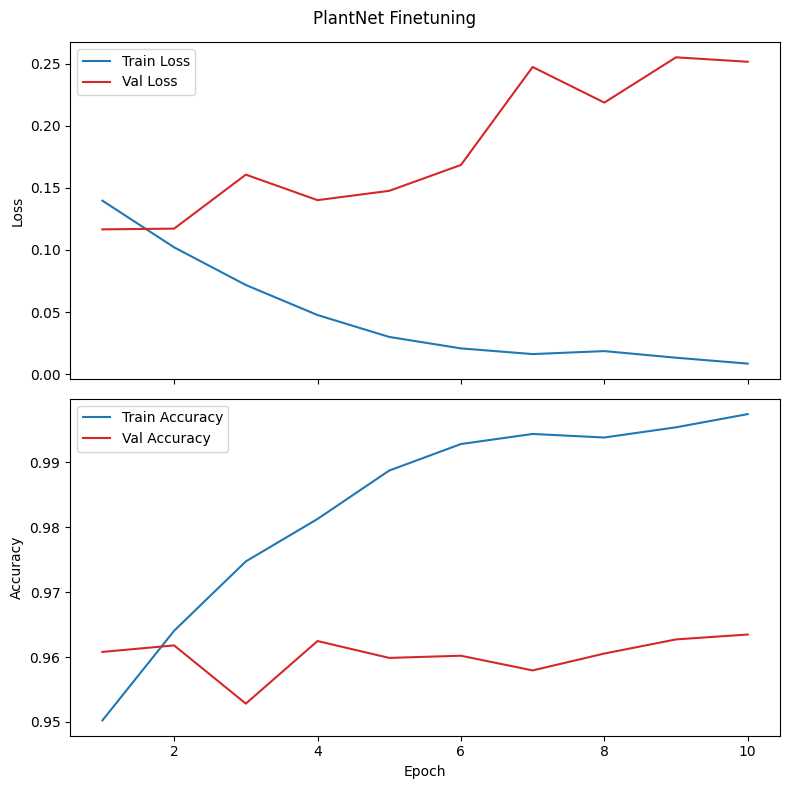

In [18]:
# Plot PlantNet training history

import matplotlib.pyplot as plt

def plot_training_history(train_stats, val_stats, title):

  epochs = range(1, len(train_stats) + 1)
  train_losses = [entry[0] for entry in train_stats]
  train_accuracies = [entry[1] for entry in train_stats]
  val_losses = [entry[0] for entry in val_stats]
  val_accuracies = [entry[1] for entry in val_stats]

  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

  fig.suptitle(title)

  train_colour = 'tab:blue'
  val_colour = 'tab:red'
  # Plotting loss
  ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
  ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
  ax1.set_ylabel('Loss')
  ax1.legend()

  # Plot accuracy
  ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
  ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.tight_layout()
  return plt.show()

plot_training_history(PlantNet_train_stats, PlantNet_val_stats, "PlantNet Finetuning")

In [20]:
# Make true labels array of val set

import numpy as np

true_labels = []
for _, labels in val_set:
  true_labels.append(labels.numpy())
true_labels = np.vstack(true_labels)


In [21]:
# Evaulate model on test set (inference)

from tqdm import tqdm
import numpy as np

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PlantNet_model.to(device)

PlantNet_model.eval()

PlantNet_Predictions = []

with torch.no_grad():
  for data in tqdm(val_set):
      inputs, labels = data
      inputs = inputs.unsqueeze(0).to(device)   # Add batch dimension and move to device

      output = PlantNet_model(inputs)
      predictions = (output > 0.5).float()      # Threshold value of 0.5

      PlantNet_Predictions.append(predictions.cpu().detach().numpy())

PlantNet_Predictions = np.squeeze(np.array(PlantNet_Predictions), axis=1)

100%|██████████| 1989/1989 [00:20<00:00, 96.48it/s]


Exact match (sklearn) accuracy: 0.8009049773755657
Keras BinaryAccuracy:           0.9634657502174377


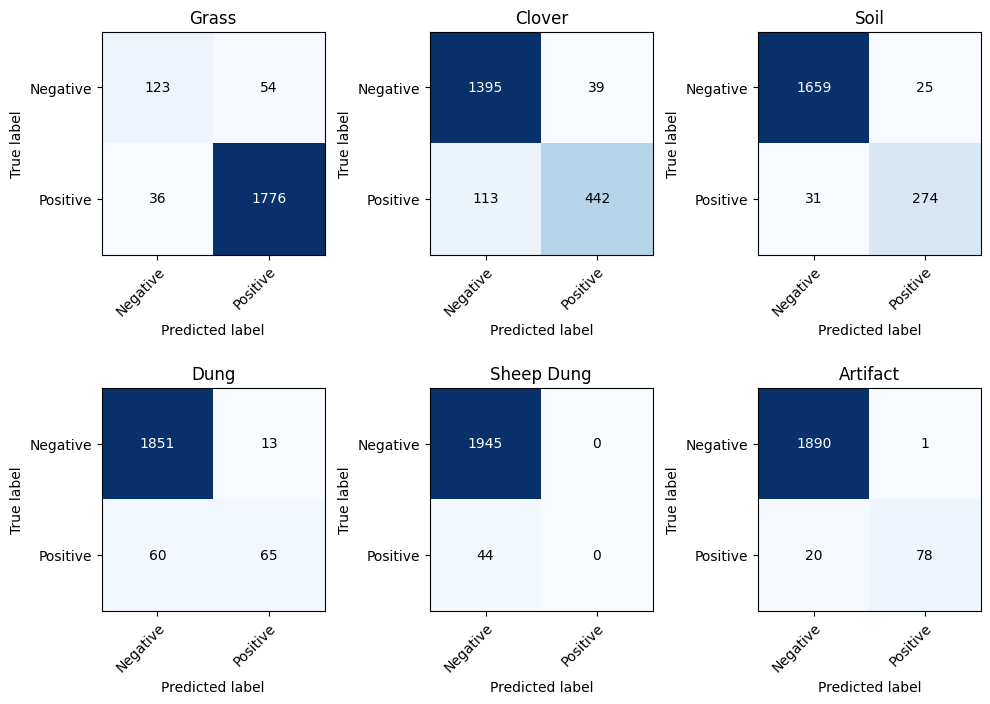

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
import keras

class_names = [label for label in label_map.keys()]

sklearn_accuracy = accuracy_score(true_labels, PlantNet_Predictions)

keras_bin_acc = keras.metrics.BinaryAccuracy()
keras_bin_acc.update_state(true_labels, PlantNet_Predictions)
keras_acc = keras_bin_acc.result()
keras_bin_acc.reset_state()

confusion_matrices = multilabel_confusion_matrix(true_labels, PlantNet_Predictions)

num_classes = len(class_names)
grid_size = int(np.ceil(np.sqrt(num_classes)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
    ax = axes[i]
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(class_name)

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for j in range(confusion_matrix.shape[0]):
        for k in range(confusion_matrix.shape[1]):
            ax.text(k, j, format(confusion_matrix[j, k], fmt),
                    ha="center", va="center",
                    color="white" if confusion_matrix[j, k] > thresh else "black")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
print(f"Exact match (sklearn) accuracy: {sklearn_accuracy}")
print(f"Keras BinaryAccuracy:           {keras_acc}")
plt.show()


Finetune iNaturalist

In [26]:
# First go to this dropbox (https://cornell.app.box.com/s/bnyhq5lwobu6fgjrub44zle0pyjijbmw) and generate download popup to get link to wget weights
!wget "https://public.boxcloud.com/d/1/b1!09ZRgcV191lHqGHR7Baf0EkyCkz-RpEJ8K5idwQHa91qNfeP_UGgnYxibV89fY9KmadsCHNYFDlctl9S2N2OQHR2mUlAqNcZwVyC47-6zGutGd2rwVE1xFy762lB-4wzQNMjqQJt3q6AFASw9ZSGmDW0r0HQlp_pKWiH9DIMwRpYlOMpz97ddSNRdxudBSVBcitMfGR1dF6ciRek6nPlife59OYRBkqWwi3kTijP12R9onnFE_txyvAqZ5lLA1Cyt7BAk8s3ey7GYPHndIybybz3gh3FrqkZx5NfPiKIPqNFtFTLRipzLJ4eyqcQMMwAuCAXL7gVBLh_hWZRyPsvp7Kf3Rxin_CXy8dzxCOogstCT2inQBjyddF-f5Zf5sS6XllEe8fZAON2rcy5hraU6h0ED9LzhiMzw1pPpFzaETA6dLgWVMloan7-n-khE9-7K0kgIi-OaPUZzq4HBvtYjwxfXBQZFX2rj2wq5lqRgauCzIsYl5reVHiY5zQmPlILtrfd6IHV0Bhk3Fv8ajD_Y2N2a4pnWJRVhMeMi-9ZQu1s1qvSw7S5fWU_aoGPGzpUQ3h4pv42heZirkOx6lK1tm7bAjCp1BOyaLMiSFzWyDm-dOI8q54p92hwYulitF1ZJ8_CXhwxuYxmFXgIETdXKAr4ijglOzfbW6zAXGU_ywngr8fYiCuuwDYi693GuP1iR7hfV1Jz9QZu6oz8za3ohUtGDH-OyRTWNUUCXZ3PZw1Ys3wry4iKm33QOGX96RRc7MRvCPcPLyxZ_6ZZ5E96-aSpNxi3fy4KANDlxsv1LZxLabs7leqOY4xSJ3HxDMlv0K569I1-FZ8IIHgNgy52shfGfEFOLCYglBjsGuFqCqx_Z0GAf-JSa4u8ER8EXBfrDUXc6IjOpvkxz4tdHCTwv_c8DPaae-7DgdZNOppH8EarPBX1JA-532YFzy04iX1JUYcf-_0-Whl6xBeD77yv_kBY1ZFOTJvD8vh8TIxw7RRoXAh740UYTL8pugMf3X3qTZoXWV4Fad22rCcR1SZJrcvY2p95bC_3qTooBoDNJpQWE3IKn9ws-NIPQJ3YqPUTBG-n8ZsnQpWjXUNXEPJZPlLAisQJU1rHnPztaJbDs5e6FYwA6dgGlps_Dts8u3Uqf-5Ha5QWqdMfr78_QZiNuqPCc-hEfUx2B1wRH8mgDlmZC4HMGKuEF4Uwrsx6iegDfUw-wk4ODKuQw2pO35UPaYS_QbMXo4CuTaOzRq2jhPz2TPhjCL2ntK2avyQH3IFHy_rUAll81KOnnU5G16AlDFt6KvuMPr2QXQbg/download" -O cvpr21_newt_pretrained_models.tar.gz

# Unzip models
!tar -xzf cvpr21_newt_pretrained_models.tar.gz

--2024-07-26 13:51:02--  https://public.boxcloud.com/d/1/b1!09ZRgcV191lHqGHR7Baf0EkyCkz-RpEJ8K5idwQHa91qNfeP_UGgnYxibV89fY9KmadsCHNYFDlctl9S2N2OQHR2mUlAqNcZwVyC47-6zGutGd2rwVE1xFy762lB-4wzQNMjqQJt3q6AFASw9ZSGmDW0r0HQlp_pKWiH9DIMwRpYlOMpz97ddSNRdxudBSVBcitMfGR1dF6ciRek6nPlife59OYRBkqWwi3kTijP12R9onnFE_txyvAqZ5lLA1Cyt7BAk8s3ey7GYPHndIybybz3gh3FrqkZx5NfPiKIPqNFtFTLRipzLJ4eyqcQMMwAuCAXL7gVBLh_hWZRyPsvp7Kf3Rxin_CXy8dzxCOogstCT2inQBjyddF-f5Zf5sS6XllEe8fZAON2rcy5hraU6h0ED9LzhiMzw1pPpFzaETA6dLgWVMloan7-n-khE9-7K0kgIi-OaPUZzq4HBvtYjwxfXBQZFX2rj2wq5lqRgauCzIsYl5reVHiY5zQmPlILtrfd6IHV0Bhk3Fv8ajD_Y2N2a4pnWJRVhMeMi-9ZQu1s1qvSw7S5fWU_aoGPGzpUQ3h4pv42heZirkOx6lK1tm7bAjCp1BOyaLMiSFzWyDm-dOI8q54p92hwYulitF1ZJ8_CXhwxuYxmFXgIETdXKAr4ijglOzfbW6zAXGU_ywngr8fYiCuuwDYi693GuP1iR7hfV1Jz9QZu6oz8za3ohUtGDH-OyRTWNUUCXZ3PZw1Ys3wry4iKm33QOGX96RRc7MRvCPcPLyxZ_6ZZ5E96-aSpNxi3fy4KANDlxsv1LZxLabs7leqOY4xSJ3HxDMlv0K569I1-FZ8IIHgNgy52shfGfEFOLCYglBjsGuFqCqx_Z0GAf-JSa4u8ER8EXBfrDUXc6IjOpvkxz4tdHCTwv_c8DPaae-7DgdZNOppH8Ear

In [28]:
# Load iNaturalist model and modify the output layer for multilabel classification

import torch
from torchvision.models import resnet50

def load_iNaturalist_model():

  model = resnet50()
  num_iNaturalist_classes = 10000 # 10,000 classes including all species
  model.fc = torch.nn.Linear(in_features=2048, out_features=num_iNaturalist_classes)

  weights_file_path = "cvpr21_newt_pretrained_models/pt/inat2021_supervised_large.pth.tar"
  checkpoint = torch.load(weights_file_path, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['state_dict'])

  return model

iNaturalist_model = load_iNaturalist_model()
iNaturalist_model = MultiLabelResNet(iNaturalist_model, new_num_classes)

In [29]:
# freeze all weights
freeze_weights(iNaturalist_model)

# unfreeze final layers for finetuning
unfreeze_after_layer4(iNaturalist_model)

In [30]:
# Finetune iNaturalist

# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
iNaturalist_optimiser = optim.Adam(iNaturalist_model.parameters(), lr=0.001)  # Adjust learning rate as needed

iNaturalist_model.to(device) # Detect if GPU is available

# Fine-tune the model
iNaturalist_model, iNaturalist_train_stats, iNtauralist_val_stats = fine_tune(iNaturalist_model, train_loader, val_loader, iNaturalist_optimiser, loss_function, num_epochs=10)

# Save the model
torch.save(iNaturalist_model.state_dict(), '/content/drive/MyDrive/team_challenge/240726_multiclass_iNaturalist.pth')

Epoch [1/10], Train loss: 0.15, Train accuracy: 0.95
Epoch [2/10], Train loss: 0.10, Train accuracy: 0.96
Epoch [3/10], Train loss: 0.08, Train accuracy: 0.97
Epoch [4/10], Train loss: 0.05, Train accuracy: 0.98
Epoch [5/10], Train loss: 0.03, Train accuracy: 0.99
Epoch [6/10], Train loss: 0.03, Train accuracy: 0.99
Epoch [7/10], Train loss: 0.02, Train accuracy: 0.99
Epoch [8/10], Train loss: 0.02, Train accuracy: 0.99
Epoch [9/10], Train loss: 0.01, Train accuracy: 1.00
Epoch [10/10], Train loss: 0.01, Train accuracy: 1.00
Fine-tuning complete in 9m 33s


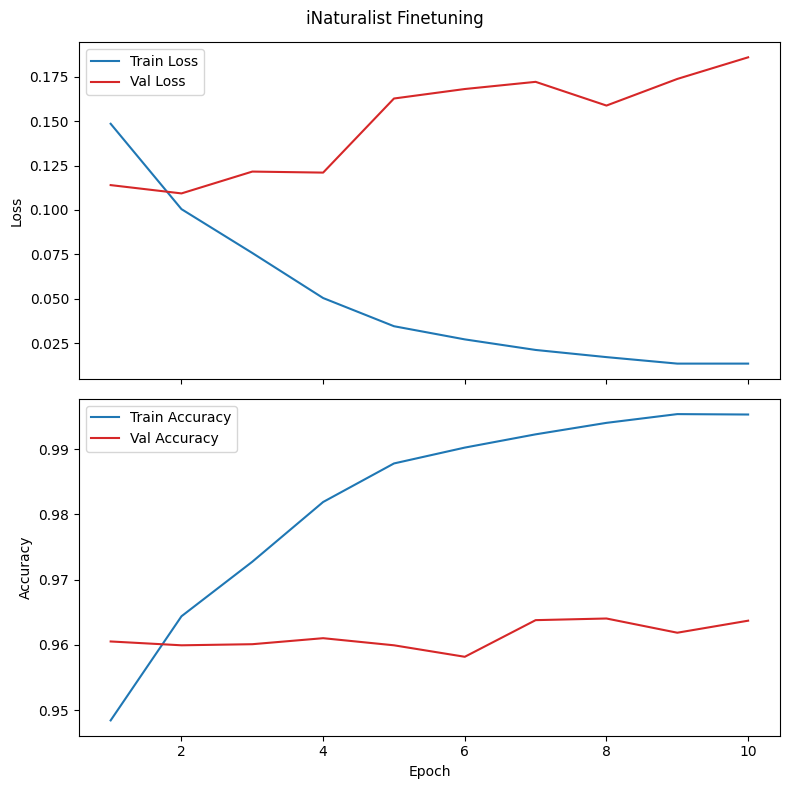

In [31]:
plot_training_history(iNaturalist_train_stats, iNtauralist_val_stats, "iNaturalist Finetuning")

In [32]:
# Evaulate model on test set (inference)

from tqdm import tqdm
import numpy as np

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
iNaturalist_model.to(device)

iNaturalist_model.eval()

iNaturalist_predictions = []

with torch.no_grad():
  for data in tqdm(val_set):
      inputs, labels = data
      inputs = inputs.unsqueeze(0).to(device)   # Add batch dimension and move to device

      output = iNaturalist_model(inputs)
      predictions = (output > 0.5).float()      # Threshold value of 0.5

      iNaturalist_predictions.append(predictions.cpu().detach().numpy())

iNaturalist_predictions = np.squeeze(np.array(iNaturalist_predictions), axis=1)

100%|██████████| 1989/1989 [00:18<00:00, 106.90it/s]


Exact match (sklearn) accuracy: 0.8049270990447461
Keras BinaryAccuracy: 0.9637171030044556


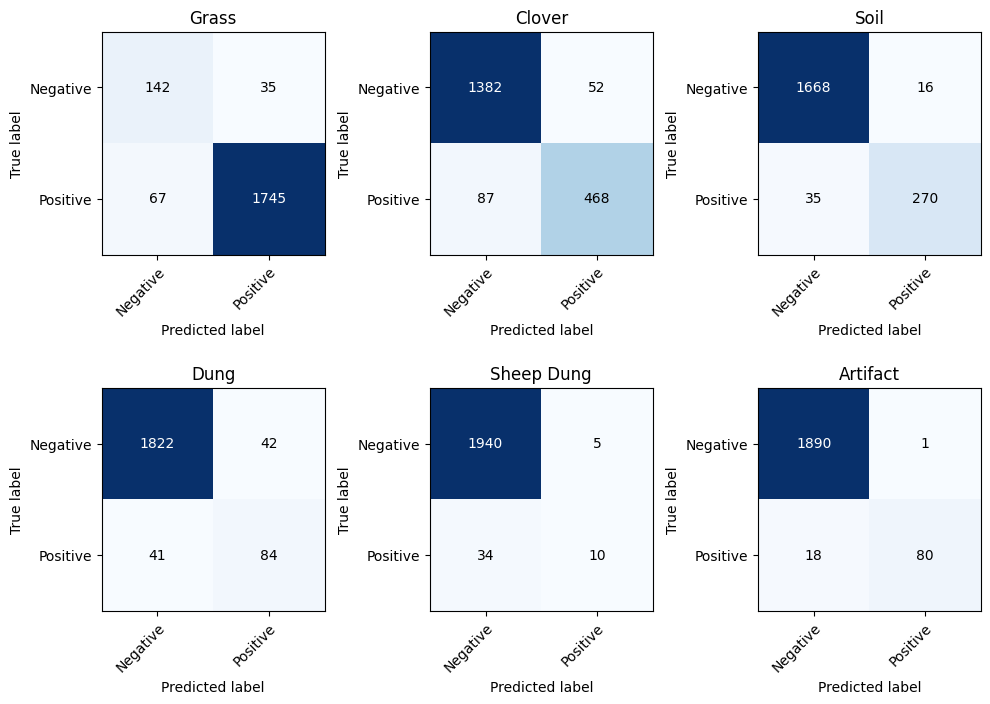

In [33]:

sklearn_accuracy = accuracy_score(true_labels, iNaturalist_predictions)

keras_bin_acc = keras.metrics.BinaryAccuracy()
keras_bin_acc.update_state(true_labels, iNaturalist_predictions)
keras_acc = keras_bin_acc.result()
keras_bin_acc.reset_state()

confusion_matrices = multilabel_confusion_matrix(true_labels, iNaturalist_predictions)

num_classes = len(class_names)
grid_size = int(np.ceil(np.sqrt(num_classes)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
    ax = axes[i]
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(class_name)

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for j in range(confusion_matrix.shape[0]):
        for k in range(confusion_matrix.shape[1]):
            ax.text(k, j, format(confusion_matrix[j, k], fmt),
                    ha="center", va="center",
                    color="white" if confusion_matrix[j, k] > thresh else "black")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
print(f"Exact match (sklearn) accuracy: {sklearn_accuracy}")
print(f"Keras BinaryAccuracy:           {keras_acc}")
plt.show()
